# Does a vector autogregressive model fit have better behaviour relative to real climate forecasts?

In [13]:
import xarray as xr

import pandas as pd

from src import utils

import matplotlib.pyplot as plt

In [36]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 12

In [9]:
DATA_DIR = "../../data/processed"

## Let's just fit to observations for now, though a fit to historical model runs may be more appropriate

In [62]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = utils.calculate_period_AMV_index(
    HadISST["sst"],
    [12, 1, 2, 3],
).rename("AMV").compute()
AMV = utils.round_to_start_of_month(AMV, dim="time")
AMV = utils.get_observation_rolling_mean(AMV, [1, 4, 8])

In [63]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = utils.calculate_period_NAO_index(
    HadSLP["slp"],
    [12, 1, 2, 3],
).rename("NAO").compute()
NAO = utils.get_observation_rolling_mean(NAO, [1, 4, 8])

In [64]:
AMV, NAO = xr.align(AMV, NAO)

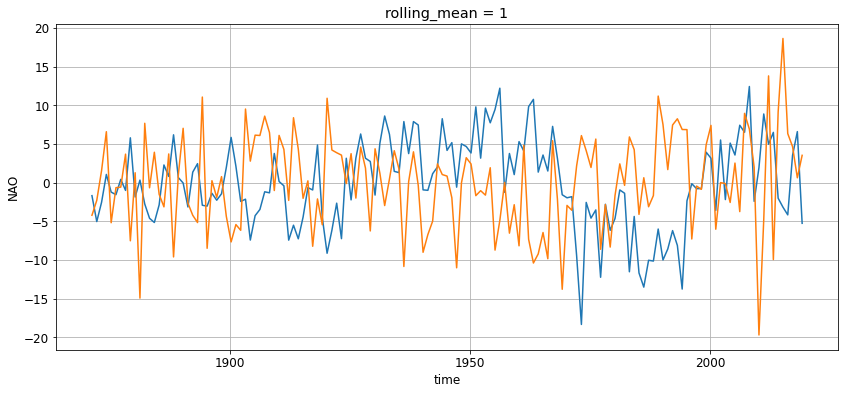

In [65]:
(40*AMV).sel(rolling_mean=1).plot(label="AMV")
NAO.sel(rolling_mean=1).plot(label="NAO")

plt.grid()

## Fit a VAR model

In [374]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [373]:
input_data = pd.concat(
    (AMV.sel(rolling_mean=1, drop=True).to_dataframe(),
    NAO.sel(rolling_mean=1, drop=True).to_dataframe()),
    axis=1
)

Check that input series are stationary

In [380]:
signif = 0.05

for var in input_data.columns:
    res = adfuller(input_data[var])
    if res[1] < signif:
        print(f"{var} is stationary")
    else:
        print(f"{var} is non-stationary")

AMV is stationary
NAO is stationary


Fit the model

In [399]:
order = 2

model = VAR(input_data)
res = model.fit(order, trend="n")
res.summary()

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, Jun, 2022
Time:                     14:58:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.635102
Nobs:                     147.000    HQIC:                 -0.731721
Log likelihood:          -350.526    FPE:                   0.450310
AIC:                    -0.797846    Det(Omega_mle):        0.426768
--------------------------------------------------------------------
Results for equation AMV
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
L1.AMV         0.435933         0.083004            5.252           0.000
L1.NAO        -0.000936         0.001562           -0.599           0.549
L2.AMV         0.258294         0.083413            3.097           0.002
L2.NAO         0

Simulate the process from a random inital condition

In [654]:
n_times = 100

inits = res.simulate_var(steps=n_times+order)[order:,...]

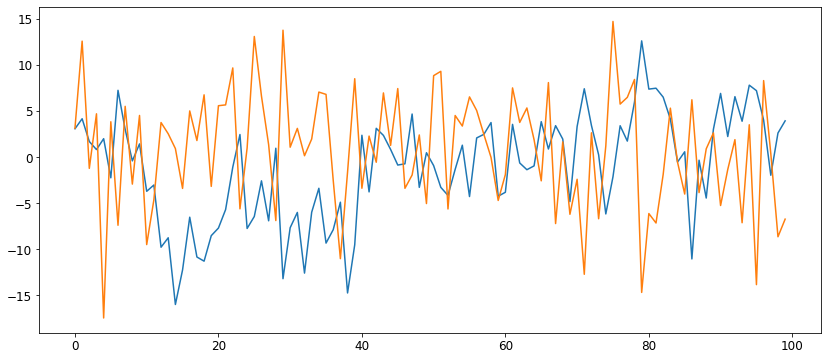

In [655]:
plt.plot(40*inits[:,0])
plt.plot(inits[:,1])

In [656]:
res.params

,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


In [657]:
res.resid.std()

AMV    0.109926
NAO    5.877573
dtype: float64

In [660]:
def predict(params, scale, inits, n_steps, n_members=1):
    """
    Advance a Vector Autoregressive model forward in time from initial conditions
    by n_steps

    Parameters
    ----------
    params : numpy array
        Array of shape [N_vars*M_lags, N_vars] containing the VAR(n) model
        coefficients as output by
        statsmodels.tsa.api.VAR(data).fit(N_lags, trend="n").params. That is, the
        coefficients along axis 0 should be ordered as 
        [ϕ_var1_lag1, ..., ϕ_varN_lag1, ..., ϕ_var1_lagM, ..., ϕ_varN_lagM]
    scale : numpy array
        1D array of length N_vars containing the standard deviation of the noise
        terms in the VAR(n) model as output by
        statsmodels.tsa.api.VAR(data).fit(order, trend="n").resid.std()
    inits : numpy array
        Array containing the initial conditions. Can be 2D or 3D. If 2D, should
        be shape [N_inits, N_vars]. If 3D, should be shape 
        [N_inits, N_vars, N_samples], where the final axis contains different
        samples of initial conditions
    n_steps : int
        The number of timesteps to step forward from each initial condition
    """

    def _epsilon(scale, size):
        return np.random.normal(scale=scale, size=size)

    N_params = params.shape[0]
    N_vars = params.shape[1]
    N_lags = int(N_params / N_vars)
    
    # Some quick checks
    assert len(inits) >= N_lags, (
        f"At least {order} initial conditions must be provided for an "
        f"AR({order}) model"
    )

    # Stack the inits as predictors and sort so that they have an appropriate 
    # order to multiply the input params, i.e.
    # [var1_lag1, ..., varN_lag1, ..., var1_lagM, ..., varN_lagM]
    inits_lagged = sliding_window_view(inits, window_shape=N_lags, axis=0)
    inits_lagged = inits_lagged.reshape((inits_lagged.shape[0], -1))
    sort_indices = np.array([list(range(N_lags-i, inits_lagged.shape[-1], N_lags)) for i in range(1,N_lags+1)]).flatten()
    inits_lagged = inits_lagged.take(sort_indices, axis=-1)
    
    # res = [init, var, lead]
    res = np.empty((*inits_lagged.shape[:-1], N_vars*n_steps + N_params), dtype="float32")
    res[:, :N_params] = inits_lagged
    for step in range(N_params, N_vars*n_steps + N_params, N_vars):
        fwd = np.matmul(res[:, step-N_params : step], params)
        
        # Add noise
        fwd += _epsilon(scale, size=fwd.shape)
        res[:, step:step+N_vars] = fwd
        
    return [res[:, i::N_lags] for i in range(N_lags)]
    
#     # res = [member, init, sample, lead]
#     res = np.empty((n_members, *inits_stacked.shape[:-1], n_steps + order), dtype="float32")
#     res[:, :, :, :order] = inits_stacked
#     for step in range(order, n_steps + order):
#         fwd = np.sum(params * res[:, :, :, step - order : step], axis=-1)

#         if scale is not None:
#             fwd += _epsilon(scale, fwd.shape)
#         res[:, :, :, step] = fwd

#     # Bundle into xarray DataArray for convenience
#     return xr.DataArray(
#         res[:, :, :, order:],
#         coords={
#             "member": range(n_members),
#             "init": range(order - 1, len(inits)),
#             "sample": range(inits.shape[1]),
#             "lead": range(1, n_steps + 1),
#         },
#     ).squeeze(drop=True)

In [687]:
a, b = predict(res.params.to_numpy(), [0,0], inits, n_steps = 20) #res.resid.std().to_numpy()

# Why are these the same!?

In [698]:
a[:,0][:-1]

array([ 0.10376919,  0.04202771,  0.0201941 ,  0.04966863, -0.05631918,
        0.18087326,  0.07477117, -0.01049399,  0.03554115, -0.09295477,
       -0.07590518, -0.2445408 , -0.21896338, -0.39984915, -0.3060837 ,
       -0.1631487 , -0.2710829 , -0.28239372, -0.21323797, -0.19264066,
       -0.14257185, -0.0274064 ,  0.06101389, -0.19368565, -0.16123822,
       -0.06460655, -0.17291266,  0.02380132, -0.32993284, -0.19171381,
       -0.15027703, -0.31475183, -0.14970131, -0.08477066, -0.23339802,
       -0.19710399, -0.12252796, -0.3685912 , -0.237931  ,  0.05900218,
       -0.09454198,  0.07780761,  0.05865602,  0.02058507, -0.02175433,
       -0.01844579,  0.11656791, -0.08223473,  0.01161682, -0.02326687,
       -0.08224357, -0.10408987, -0.03352553,  0.03206073, -0.10718169,
        0.0518002 ,  0.06148093,  0.09343968, -0.10621977, -0.09559213,
        0.088512  , -0.01608364, -0.03439377, -0.02403121,  0.09586979,
        0.02175951,  0.085033  ,  0.0486617 , -0.12087072,  0.08

In [699]:
a[:,1][1:]

array([ 0.10376919,  0.04202771,  0.0201941 ,  0.04966863, -0.05631918,
        0.18087326,  0.07477117, -0.01049399,  0.03554115, -0.09295477,
       -0.07590518, -0.2445408 , -0.21896338, -0.39984915, -0.3060837 ,
       -0.1631487 , -0.2710829 , -0.28239372, -0.21323797, -0.19264066,
       -0.14257185, -0.0274064 ,  0.06101389, -0.19368565, -0.16123822,
       -0.06460655, -0.17291266,  0.02380132, -0.32993284, -0.19171381,
       -0.15027703, -0.31475183, -0.14970131, -0.08477066, -0.23339802,
       -0.19710399, -0.12252796, -0.3685912 , -0.237931  ,  0.05900218,
       -0.09454198,  0.07780761,  0.05865602,  0.02058507, -0.02175433,
       -0.01844579,  0.11656791, -0.08223473,  0.01161682, -0.02326687,
       -0.08224357, -0.10408987, -0.03352553,  0.03206073, -0.10718169,
        0.0518002 ,  0.06148093,  0.09343968, -0.10621977, -0.09559213,
        0.088512  , -0.01608364, -0.03439377, -0.02403121,  0.09586979,
        0.02175951,  0.085033  ,  0.0486617 , -0.12087072,  0.08

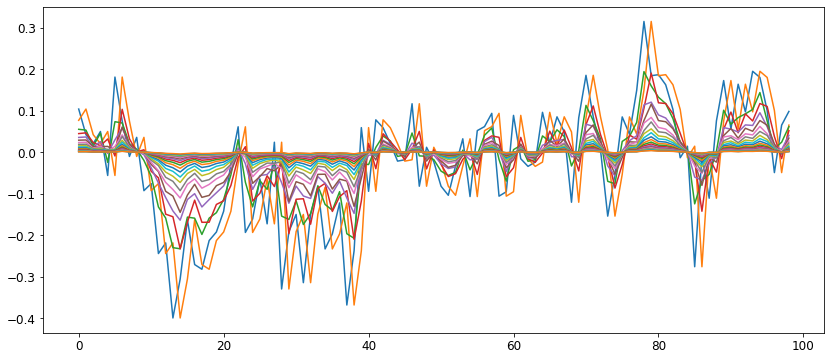

In [688]:
plt.plot(a)

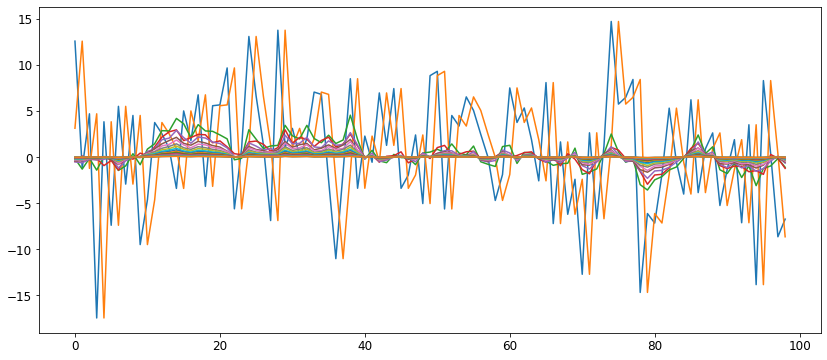

In [ ]:
plt.plot(b)

In [450]:
res.params.to_numpy()

array([[ 4.35932606e-01, -1.67650882e+00],
       [-9.35729760e-04,  6.22398387e-02],
       [ 2.58293532e-01, -9.74244953e+00],
       [ 5.38609850e-04, -1.21592281e-02]])

In [541]:
cur

array(['y1_lag1', 'y2_lag1', 'y3_lag1', 'y1_lag2', 'y2_lag2', 'y3_lag2',
       'y1_lag3', 'y2_lag3', 'y3_lag3', 'y1_lag4', 'y2_lag4', 'y3_lag4'],
      dtype='<U7')

In [440]:
N_lags = 4
N_vars = 3
np.concatenate([cur[i::N_vars][::-1] for i in range(N_vars)])

array(['y1_lag4', 'y1_lag3', 'y1_lag2', 'y1_lag1', 'y2_lag4', 'y2_lag3',
       'y2_lag2', 'y2_lag1', 'y3_lag4', 'y3_lag3', 'y3_lag2', 'y3_lag1'],
      dtype='<U7')

In [188]:
from numpy.lib.stride_tricks import sliding_window_view

In [507]:
inits = np.array([["a","q"],["b","r"],["c","s"],["d", "t"],["e","u"],["f","v"],["g","w"],["h","x"],["i","y"],["j","z"]])

In [585]:
N_vars = 2
N_lags = 3

inits_lagged = sliding_window_view(inits, window_shape=N_lags, axis=0)
inits_lagged = np.reshape(inits_lagged,(inits_lagged.shape[0], -1))
sort_indices = np.array([list(range(N_lags-i, inits_lagged.shape[-1], N_lags)) for i in range(1,N_lags+1)]).flatten()

In [588]:
sort_indices

array([2, 5, 1, 4, 0, 3])

In [589]:
inits_lagged

array([['a', 'b', 'c', 'q', 'r', 's'],
       ['b', 'c', 'd', 'r', 's', 't'],
       ['c', 'd', 'e', 's', 't', 'u'],
       ['d', 'e', 'f', 't', 'u', 'v'],
       ['e', 'f', 'g', 'u', 'v', 'w'],
       ['f', 'g', 'h', 'v', 'w', 'x'],
       ['g', 'h', 'i', 'w', 'x', 'y'],
       ['h', 'i', 'j', 'x', 'y', 'z']], dtype='<U1')

array([['c', 's', 'b', 'r', 'a', 'q'],
       ['d', 't', 'c', 's', 'b', 'r'],
       ['e', 'u', 'd', 't', 'c', 's'],
       ['f', 'v', 'e', 'u', 'd', 't'],
       ['g', 'w', 'f', 'v', 'e', 'u'],
       ['h', 'x', 'g', 'w', 'f', 'v'],
       ['i', 'y', 'h', 'x', 'g', 'w'],
       ['j', 'z', 'i', 'y', 'h', 'x']], dtype='<U1')

In [ ]:
[1,3,0,2]

In [ ]:
[i

In [523]:
inits_lagged[...,::N_vars]

array([['a', 'r'],
       ['b', 's'],
       ['c', 't'],
       ['d', 'u'],
       ['e', 'v'],
       ['f', 'w'],
       ['g', 'x'],
       ['h', 'y'],
       ['i', 'z']], dtype='<U1')

In [521]:
np.concatenate([inits_lagged[...,i::N_vars][::-1] for i in range(N_vars)])

(9, 4)

In [514]:
res.params

,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


In [205]:
inits_stacked = sliding_window_view(inits, window_shape=2, axis=0)
inits_stacked = inits_stacked.reshape((inits_stacked.shape[0], -1))

### As a check, do the fit myself

In [361]:
order = 2

In [362]:
input_data = pd.concat(
    (AMV.sel(rolling_mean=1, drop=True).to_dataframe(),
    NAO.sel(rolling_mean=1, drop=True).to_dataframe()),
    axis=1
)

In [363]:
def OLS_fit(predictor, response):
    XtX = np.matmul(predictor.T, predictor)
    XtY = np.matmul(predictor.T, response)
    XtX_Inv = np.linalg.inv(XtX)
    
    b = np.matmul(XtX_Inv, XtY)
    
    return b

In [368]:
# Lag order with this approach is [y1_lag2, y1_lag1, y2_lag2, y2_lag1]
predictor = sliding_window_view(input_data.to_numpy(), window_shape=order, axis=0)
predictor = predictor.reshape((predictor.shape[0], -1))[:-1,:]

response = input_data.to_numpy()[order:]

my_params = pd.DataFrame(
    OLS_fit(predictor, response), 
    index = ["L2.AMV", "L1.AMV", "L2.NAO", "L1.NAO"], 
    columns = ['AMV','NAO']
)
my_params

,AMV,NAO
L2.AMV,0.258294,-9.742450
L1.AMV,0.435933,-1.676509
L2.NAO,0.000539,-0.012159
L1.NAO,-0.000936,0.062240


In [369]:
their_params = VAR(input_data).fit(order, trend="n").params
their_params

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


## Check that `res.sigma2` returned by `statsmodels` is just the std of the residuals

In [371]:
from statsmodels.tsa.ar_model import AutoReg

res = AutoReg(input_data.to_numpy()[:,0], lags=2,trend="n").fit()

print(f"Square root of res.sigma2: {np.sqrt(res.sigma2)}")
print(f"Standard deviation of residuals: {np.std(res.resid)}")

Square root of res.sigma2: 0.10972550897069776
Standard deviation of residuals: 0.10972513235786074


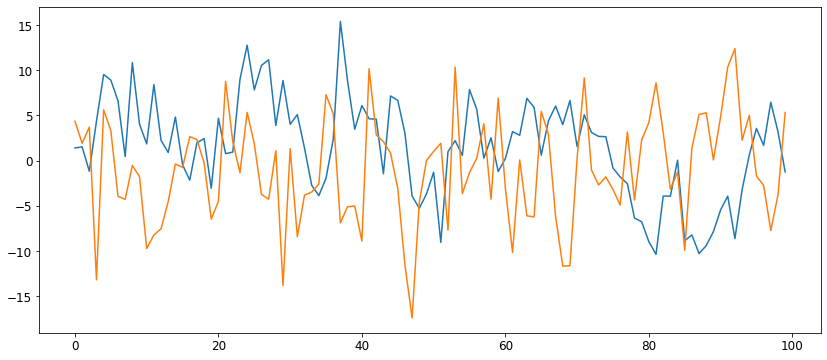

In [167]:
plt.plot((40*init[:,0]))
plt.plot(init[:,1])

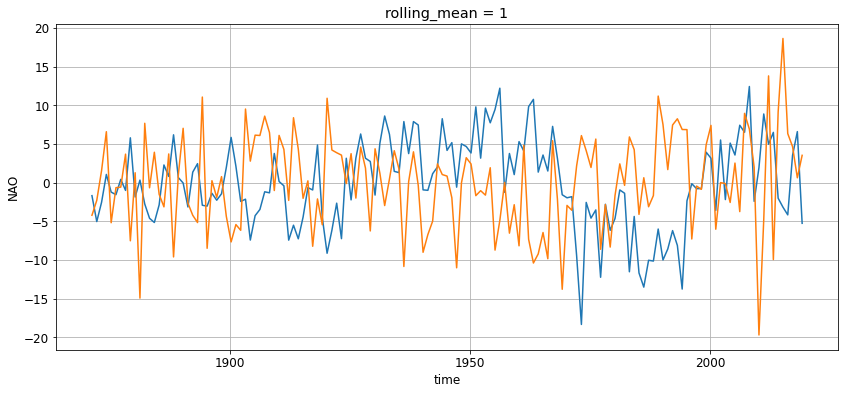

In [153]:
(40*AMV).sel(rolling_mean=1).plot(label="AMV")
NAO.sel(rolling_mean=1).plot(label="NAO")

plt.grid()